In [1]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Data Exploration
import missingno as miss

# Data Visualization
from matplotlib import cm
from pandas.plotting import table

# Data Cleaning
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Specialized Tools
import country_converter as coco
cc = coco.CountryConverter()

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
# Function found at 
# https://stackoverflow.com/questions/26678467/export-a-pandas-dataframe-as-a-table-image

from bokeh.io import export_png, export_svgs           
from bokeh.models import ColumnDataSource, DataTable, TableColumn
              
def save_df_as_image(df, path):
    source = ColumnDataSource(df)
    df_columns = [df.index.name]
    df_columns.extend(df.columns.values)
    columns_for_table=[]
    for column in df_columns:
        columns_for_table.append(TableColumn(field=column, title=column))

    data_table = DataTable(source=source, columns=columns_for_table,height_policy="auto",width_policy="auto",index_position=None)
    export_png(data_table, filename = path)

# Data Wrangling

Here I will be importing, merging, exploring, cleaning, and pre-processing the data.

# Importing

In [3]:
# Imports all of the datasets
happy = pd.read_csv("../Data/happiness.csv")
hours = pd.read_csv("../Data/ilostat_hours_worked.csv")
ineq = pd.read_csv("../Data/ilostat_inequality.csv")
unions = pd.read_csv("../Data/ilostat_unions.csv")
union_density = pd.read_csv("../Data/ilostat_union_density.csv")
work_safety = pd.read_csv("../Data/ilostat_work_safety.csv")
min_wage = pd.read_csv("../Data/ilostat_min_wage.csv")
gen_gap = pd.read_csv("../Data/ilostat_gender_pay_gap.csv")
mean_earn = pd.read_csv("../Data/ilostat_mean_monthly_earnings.csv")
f_low_percent = pd.read_csv("../Data/ilostat_female_low_income.csv")
vdem = pd.read_csv("../Data/VDEM_core.csv")
econ = pd.read_excel("../Data/maddison_proj_econ_metrics.xlsx", sheet_name = "GDP pc")

# Merging

Our goal here is to merge each dataset such that there is one row per country per year. Some cleaning of some of these datasets will be necessary prior to merging.

## Happiness
The following are preparations for merging the happiness dataset.

In [4]:
# Renames columns
happy = happy.rename({"Entity":"Country", 
                      "Life satisfaction in Cantril Ladder (World Happiness Report 2019)":"Life_Satisfaction"}, 
                     axis = 1)

In [5]:
# Standardizes Country Names
happy["Country"] = cc.convert(names = happy["Country"].tolist(), to = 'name_short', not_found=None)

In [6]:
happy.sample(5)

,Country,Code,Year,Life_Satisfaction
244,Cambodia,KHM,2018,5.121838
1425,Sudan,SDN,2010,4.435160
54,Armenia,ARM,2014,4.453083
943,Mali,MLI,2011,4.666833
1079,New Zealand,NZL,2008,7.381171


## Weekly Hours Worked
The following are preparations for merging the hours worked dataset.

In [7]:
# Renames important columns
hours = hours.rename({"ref_area.label":"Country", 
                      "time":"Year",
                      "sex.label":"Sex", 
                      "obs_value":"Avg_Hours_Worked"}, axis = 1)

In [8]:
# Keeps only the total hours worked per week, not the data split by male or female
hours = hours.loc[hours["Sex"] == "Sex: Total"]

In [9]:
# Removes extraneous columns
hours = hours[["Country", "Year", "Avg_Hours_Worked"]]

In [10]:
# Standardizes Country Names
hours["Country"][hours["Country"] == "Macau, China"] = "Macau"
hours["Country"] = cc.convert(names = hours["Country"].tolist(), to = 'name_short', not_found=None)

In [11]:
hours.sample(5)

,Country,Year,Avg_Hours_Worked
435,Costa Rica,2008,46.180900
1386,Venezuela,2005,41.794200
21,Albania,2013,41.842300
60,Australia,2001,36.998664
477,Dominican Republic,2004,42.011100


## Inequality
The following are preparations for merging the inequality dataset.

In [12]:
# Renames important columns
ineq = ineq.rename({"ref_area.label":"Country", 
                      "time":"Year",
                      "classif1.label":"Income_Decile",
                      "obs_value":"Income_Labor_Income"}, axis = 1)

In [13]:
# Creates two temporary datasets for the two measures of inequality we will use
ineq_frac = ineq.copy()
ineq_diff = ineq.copy()

In [14]:
# Keeps only the bottom 5 Deciles and the top two Deciles
ineq_diff = ineq_diff.loc[~ineq_diff["Income_Decile"].isin(["Decile: Decile 6", "Decile: Decile 7", "Decile: Decile 8"])]

In [15]:
# Replace the remaining names with "Bottom_Half" or "Top_Quintile"
ineq_diff["Income_Decile"] = ineq_diff["Income_Decile"].replace({"Decile: Decile 1":"Bottom_Half", 
                                                       "Decile: Decile 2":"Bottom_Half",
                                                       "Decile: Decile 3":"Bottom_Half",
                                                       "Decile: Decile 4":"Bottom_Half",
                                                       "Decile: Decile 5":"Bottom_Half",
                                                       "Decile: Decile 9":"Top_Quintile",
                                                       "Decile: Decile 10":"Top_Quintile"})

In [16]:
# Sums the proportional earnings for the bottom half and top quintile
# of each country's labor force
ineq_diff = ineq_diff.groupby(["Country", "Year", "Income_Decile"]).sum().reset_index()

In [17]:
# Calculates the difference in income of labor in the top 20%
# vs. the income of labor in the bottom 50%
ineq["Ineq_Frac"] = ineq["Income_Labor_Income"].div(ineq["Income_Labor_Income"].shift(1))
ineq_diff["Ineq_Diff"] = ineq_diff["Income_Labor_Income"].diff()

In [18]:
# Removes the half of the data that contains the wrong values
ineq_diff = ineq_diff.loc[ineq_diff["Income_Decile"] == "Top_Quintile"]

In [19]:
# Retains only the necessary columns
ineq_diff = ineq_diff[["Country", "Year", "Ineq_Diff"]]

In [20]:
# Keeps only the bottom 2 Deciles and the top two Deciles
ineq_frac = ineq_frac.loc[~ineq_frac["Income_Decile"].isin(["Decile: Decile 3","Decile: Decile 4",
                                                            "Decile: Decile 5","Decile: Decile 6", 
                                                            "Decile: Decile 7", "Decile: Decile 8"])]

In [21]:
# Replace the remaining names with "Bottom_Half" or "Top_Quintile"
ineq_frac["Income_Decile"] = ineq_frac["Income_Decile"].replace({"Decile: Decile 1":"Bottom_Quintile", 
                                                       "Decile: Decile 2":"Bottom_Quintile",
                                                       "Decile: Decile 9":"Top_Quintile",
                                                       "Decile: Decile 10":"Top_Quintile"})

In [22]:
# Sums the proportional earnings for the bottom half and top quintile
# of each country's labor force
ineq_frac = ineq_frac.groupby(["Country", "Year", "Income_Decile"]).sum().reset_index()

In [23]:
# Calculates how many times greater the top 20%'s incomes are
# than the bottom 20%
ineq_frac["Ineq_Frac"] = ineq_frac["Income_Labor_Income"].div(ineq_frac["Income_Labor_Income"].shift(1))

In [24]:
# Removes the half of the data that contains the wrong values
ineq_frac = ineq_frac.loc[ineq_frac["Income_Decile"] == "Top_Quintile"]

In [25]:
# Retains only the necessary columns
ineq_frac = ineq_frac[["Country", "Year", "Ineq_Frac"]]

In [26]:
# Merge the two measures of inequality
ineq = pd.merge(ineq_diff, ineq_frac, on = ["Country", "Year"])

In [27]:
# Standardizes Country Names
ineq["Country"][ineq["Country"] == "Macau, China"] = "Macau"
ineq["Country"] = cc.convert(names = ineq["Country"].tolist(), to = 'name_short', not_found=None)

<ipython-input-27-2faefac0d509>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ineq["Country"][ineq["Country"] == "Macau, China"] = "Macau"
ASEAN not found in regex
ASEAN not found in regex
ASEAN not found in regex
ASEAN not found in regex
ASEAN not found in regex
ASEAN not found in regex
ASEAN not found in regex
ASEAN not found in regex
ASEAN not found in regex
ASEAN not found in regex
ASEAN not found in regex
ASEAN not found in regex
ASEAN not found in regex
ASEAN not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa no

### Variable Descriptions

As these variables were created, they require some definition.

`Ineq_Frac` shows the percent of a country's total labor income the top 20% earn more than the bottom 50%. Thus, an `Ineq_Diff` of 45% means the top 20% of laborers in a country receive 45% more of the nation's labor income than the bottom 50% of laborers. This could mean the top 20% take home 65% of the nation's total labor income while the bottom 50% take home 20%.

`Ineq_Frac` divides the fraction a country's total labor income the top 20% earn by the earnings of the bottom 20%. Thus, if the top 20% earn 50% of the nation's total labor income and the bottom 20% earn 5%, then `Ineq_Frac` will equal 10. *Essentially, this number is how many times more the wealthy earn than the poor in a country.*

***These two variables will be highly correlated.***

In [28]:
ineq.sample(5)

,Country,Year,Ineq_Diff,Ineq_Frac
2907,United States,2013,27.375078,10.861498
352,Bosnia and Herzegovina,2006,17.873326,11.884384
1559,Lebanon,2009,39.805057,17.633983
2581,Spain,2009,18.235063,7.420428
1157,Guam,2013,26.921678,12.863793


## Union Membership
The following are preparations for merging the union membership dataset.

In [29]:
# Renames important columns
unions = unions.rename({"ref_area.label":"Country", 
                      "time":"Year",
                      "obs_value":"U_Coverage"}, axis = 1)

In [30]:
# Removes extraneous columns
unions = unions[["Country", "Year", "U_Coverage"]]

In [31]:
# Standardizes Country Names
unions["Country"][unions["Country"] == "Macau, China"] = "Macau"
unions["Country"] = cc.convert(names = unions["Country"].tolist(), to = 'name_short')

In [32]:
unions.sample(5)

,Country,Year,U_Coverage
575,Namibia,2004,30.5
577,Niger,2008,35.6
119,Switzerland,2004,19.5
295,Finland,2010,68.3
816,Ukraine,2015,43.8


## Union Density
The following are preparations for merging the union density rate dataset.

In [33]:
# Renames important columns
union_density = union_density.rename({"ref_area.label":"Country", 
                                      "time":"Year",
                                      "obs_value":"U_Density"}, axis = 1)

In [34]:
# Removes extraneous columns
union_density = union_density[["Country", "Year", "U_Density"]]

In [35]:
# Standardizes Country Names
union_density["Country"][union_density["Country"] == "Macau, China"] = "Macau"
union_density["Country"] = cc.convert(names = union_density["Country"].tolist(), to = 'name_short')

In [36]:
union_density.sample(5)

,Country,Year,U_Density
122,Switzerland,2007,18.5
117,Switzerland,2002,19.9
272,Estonia,2007,7.6
127,Switzerland,2012,16.6
727,Singapore,2011,18.9


## Work Safety
The following are preparations for merging the non-fatal occupational injuries per 100,000 workers dataset.

In [37]:
# Keeps only the total hours worked per week, not the data split by industry
work_safety = work_safety.loc[work_safety["classif1.label"] == "Economic activity (ISIC-Rev.3.1): Total"]

In [38]:
# Renames important columns
work_safety = work_safety.rename({"ref_area.label":"Country", 
                                      "time":"Year",
                                      "obs_value":"Injuries_per_100000_Workers"}, axis = 1)

In [39]:
# Removes extraneous columns
work_safety = work_safety[["Country", "Year", "Injuries_per_100000_Workers"]]

In [40]:
# Standardizes Country Names
work_safety["Country"][work_safety["Country"] == "Macau, China"] = "Macau"
work_safety["Country"] = cc.convert(names = work_safety["Country"].tolist(), to = 'name_short')

In [41]:
work_safety.sample(5)

,Country,Year,Injuries_per_100000_Workers
7016,Sri Lanka,2005,46.290000
731,Azerbaijan,2007,20.000000
7115,Lithuania,2001,248.000000
8217,Moldova,2014,85.000000
220,Australia,2014,912.783693


## Minimum Wage
The following are preparations for merging the statutory minimum wage dataset.

In [42]:
# Renames important columns
min_wage = min_wage.rename({"ref_area.label":"Country", 
                                      "time":"Year",
                                      "obs_value":"Min_Wage"}, axis = 1)

In [43]:
# Removes extraneous columns
min_wage = min_wage[["Country", "Year", "Min_Wage"]]

In [44]:
# Standardizes Country Names
min_wage["Country"][min_wage["Country"] == "Macau, China"] = "Macau"
min_wage["Country"] = cc.convert(names = min_wage["Country"].tolist(), to = 'name_short')

In [45]:
min_wage.sample(5)

,Country,Year,Min_Wage
972,Lesotho,2011,128.77
1262,Pakistan,2009,73.43
966,Lesotho,2005,105.83
1203,Netherlands,2001,1057.20
1388,Rwanda,2011,3.61


## Gender Pay Gap
The following are preparations for merging the Gender Pay Gap dataset.

In [46]:
# Renames important columns
gen_gap = gen_gap.rename({"ref_area.label":"Country", 
                                      "time":"Year",
                                      "obs_value":"Gender_Gap"}, axis = 1)

In [47]:
# Removes extraneous columns
gen_gap = gen_gap[["Country", "Year", "Gender_Gap"]]

In [48]:
# Standardizes Country Names
gen_gap["Country"][gen_gap["Country"] == "Macau, China"] = "Macau"
gen_gap["Country"] = cc.convert(names = gen_gap["Country"].tolist(), to = 'name_short')

In [49]:
gen_gap.sample(5)

,Country,Year,Gender_Gap
100,Ecuador,2004,11.11
84,Dominican Republic,2016,-3.85
231,Portugal,2008,11.74
123,Spain,2018,17.65
257,Paraguay,2015,-1.77


## Mean Monthly Earninggs
The following are preparations for merging the mean monthly earnings dataset.

In [50]:
# Renames important columns
mean_earn = mean_earn.rename({"ref_area.label":"Country", 
                                      "time":"Year",
                                      "obs_value":"Mean_Earnings"}, axis = 1)

In [51]:
# Removes extraneous columns
mean_earn = mean_earn[["Country", "Year", "Mean_Earnings"]]

In [52]:
# Standardizes Country Names
mean_earn["Country"][mean_earn["Country"] == "Macau, China"] = "Macau"
mean_earn["Country"] = cc.convert(names = mean_earn["Country"].tolist(), to = 'name_short')

In [53]:
mean_earn.sample(5)

,Country,Year,Mean_Earnings
968,Philippines,2009,185.57
660,Japan,2018,2772.97
869,Mauritius,2013,545.47
639,Jamaica,2004,681.44
63,Azerbaijan,2010,413.01


## Percent of Low Income Earners that are Female
The following are preparations for merging the share of low income earners that are female dataset.

In [54]:
# Renames important columns
f_low_percent = f_low_percent.rename({"ref_area.label":"Country", 
                                      "time":"Year",
                                      "obs_value":"Low_Inc_Female"}, axis = 1)

In [55]:
# Removes extraneous columns
f_low_percent = f_low_percent[["Country", "Year", "Low_Inc_Female"]]

In [56]:
# Standardizes Country Names
f_low_percent["Country"][f_low_percent["Country"] == "Macau, China"] = "Macau"
f_low_percent["Country"] = cc.convert(names = f_low_percent["Country"].tolist(), to = 'name_short')

In [57]:
f_low_percent.sample(5)

,Country,Year,Low_Inc_Female
196,Philippines,2018,50.99
111,Iceland,2013,75.76
128,Israel,2011,54.96
57,Denmark,2017,52.57
205,Portugal,2010,56.52


## VDEMS
The following are preparations for merging the VDEMs dataset.

In [58]:
# Selects only the columns I want
vdem = vdem[["country_name", "country_text_id", "year", "v2x_polyarchy",
             "v2elsuffrage", "v2x_diagacc_osp", "v2xca_academ",
#             "v2mecenefm", "v2mecenefi",
#             "v2csreprss", "v2csrlgrep",  "v2clgencl", "v2cafexch", 
             "v2x_regime"]]

In [59]:
# Renames columns
vdem = vdem.rename({"country_name":"Country", 
                    "country_text_id":"Code",
                    "year":"Year", 
                    "v2x_polyarchy":"EDI",
                    "v2elsuffrage":"Suffrage",
                    "v2x_diagacc_osp":"Diag_Account",
                    "v2xca_academ":"AFI",
#                    "v2csreprss":"CSO_Repression",
#                    "v2csrlgrep":"Religious_Repression",
#                    "v2mecenefm":"Media_Censorship",
#                    "v2mecenefi":"Internet_Censorship",
#                    "v2clgencl":"Political_Group_Equality",
#                    "v2cafexch":"Academic_Exchange_Freedom",
                    "v2x_regime":"Regime_Type"}, axis = 1)

In [60]:
# Adds a column for whether a country is a democracy or not
vdem["Democracy"] = np.where((vdem["Regime_Type"] == 0) | (vdem["Regime_Type"] == 1), 0, 1)
vdem["Democracy"] = np.where(vdem["Regime_Type"].isna(), np.nan, vdem["Democracy"])

In [61]:
# Changes the column to either universal or non-universal suffrage
#vdem["Universal_Suffrage"] = np.where((vdem["Suffrage_Percent"] == 100.0), 1, 0)
# Sets to 0 for any pure autocracies
#vdem["Universal_Suffrage"] = np.where((vdem["Regime_Type"] == 0), 0, vdem["Universal_Suffrage"])

In [62]:
# Removes the Regime Type and Suffrage percent column
vdem = vdem.drop(["Regime_Type"], axis = 1)

In [63]:
vdem.sample(5)

,Country,Code,Year,EDI,Suffrage,Diag_Account,AFI,Democracy
20282,Cuba,CUB,1987,0.073,100.0,0.081,0.098,0.0
14176,Spain,ESP,1801,0.022,0.0,NaN,NaN,NaN
4292,Mali,MLI,1935,0.035,1.0,0.209,NaN,0.0
826,Ghana,GHA,1924,0.075,0.0,0.443,NaN,0.0
1191,Japan,JPN,1938,0.178,50.0,0.266,0.252,0.0


## Economic Data
The following are preparations for merging the Maddison Project Database (2020).

In [64]:
# Transposes the dataframe
econ = econ.T.reset_index()

In [65]:
# Sets column names to the first row
new_header = econ.iloc[0]
econ = econ[1:] 
econ.columns = new_header 

In [66]:
# Melts such that we get the desired columns
econ = pd.melt(econ, 
               id_vars=["GDP pc 2011 prices", "year"], 
               value_vars = new_header[2:].values )

In [67]:
# Resets column names
econ = econ.rename({"GDP pc 2011 prices":"Country", 
                    "year":"Code",
                    0:"Year",
                    "value":"GDPpc"}, axis = 1)

In [68]:
# Changes the GDPpc variable to a float from a string
econ["GDPpc"] = [float(i) for i in econ["GDPpc"].values]

In [69]:
econ.sample(5)

,Country,Code,Year,GDPpc
47653,Yemen,YEM,1527,NaN
43084,Ukraine,UKR,1500,NaN
20937,Tajikistan,TJK,1369,NaN
4435,Dominica,DMA,1272,NaN
108242,Republic of Korea,KOR,1886,NaN


## Merging Trimmed Data
The data on work safety is commented out as we lose data when merging it for some reason. It's also incredibly sparse.

In [107]:
# Merges all datasets
df = pd.merge(happy, vdem, how = "left", on = ["Code", "Year"])
df = df.drop(["Country_y"], axis = 1).rename({"Country_x":"Country"}, axis = 1)
df = pd.merge(df, econ, how = "left", on = ["Code", "Year"])
df = df.drop(["Country_y", "Code"], axis = 1).rename({"Country_x":"Country"}, axis = 1)
df = pd.merge(df, hours, how = "left", on = ["Country", "Year"])
df = pd.merge(df, unions, how = "left", on = ["Country", "Year"])
df = pd.merge(df, union_density, how = "left", on = ["Country", "Year"])
df = pd.merge(df, ineq, how = "left", on = ["Country", "Year"])
df = pd.merge(df, min_wage, how = "left", on = ["Country", "Year"])
df = pd.merge(df, gen_gap, how = "left", on = ["Country", "Year"])
df = pd.merge(df, mean_earn, how = "left", on = ["Country", "Year"])
df = pd.merge(df, f_low_percent, how = "left", on = ["Country", "Year"])

In [108]:
#save_df_as_image(df.sample(5), 'Figures/Raw_Data.png')

In [109]:
df.sample(5)

,Country,Year,Life_Satisfaction,EDI,Suffrage,Diag_Account,AFI,Democracy,GDPpc,Avg_Hours_Worked,U_Coverage,U_Density,Ineq_Diff,Ineq_Frac,Min_Wage,Gender_Gap,Mean_Earnings,Low_Inc_Female
1001,Moldova,2016,5.577784,0.569,100.0,0.717,NaN,1.0,6068.000000,NaN,23.9,23.9,25.853613,8.936458,50.19,NaN,250.85,NaN
893,Luxembourg,2016,6.967341,0.896,100.0,0.957,NaN,1.0,57006.000000,NaN,32.0,32.0,16.942508,6.424993,2128.53,NaN,5289.19,NaN
7,Afghanistan,2015,3.982855,0.396,100.0,0.741,NaN,0.0,1928.000000,NaN,NaN,NaN,73.515373,210.694083,81.77,NaN,NaN,NaN
50,Armenia,2010,4.367811,0.369,100.0,0.786,0.672,0.0,8330.811175,NaN,35.8,35.8,25.489301,9.930377,80.29,NaN,274.72,60.3
1328,Sierra Leone,2018,4.305683,0.589,100.0,0.922,0.778,1.0,1683.849683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
# Saves the new dataframe
df.to_csv("../Data/GeneratedData/Raw_Data.csv")

# Exploration & Cleaning

## Missingness

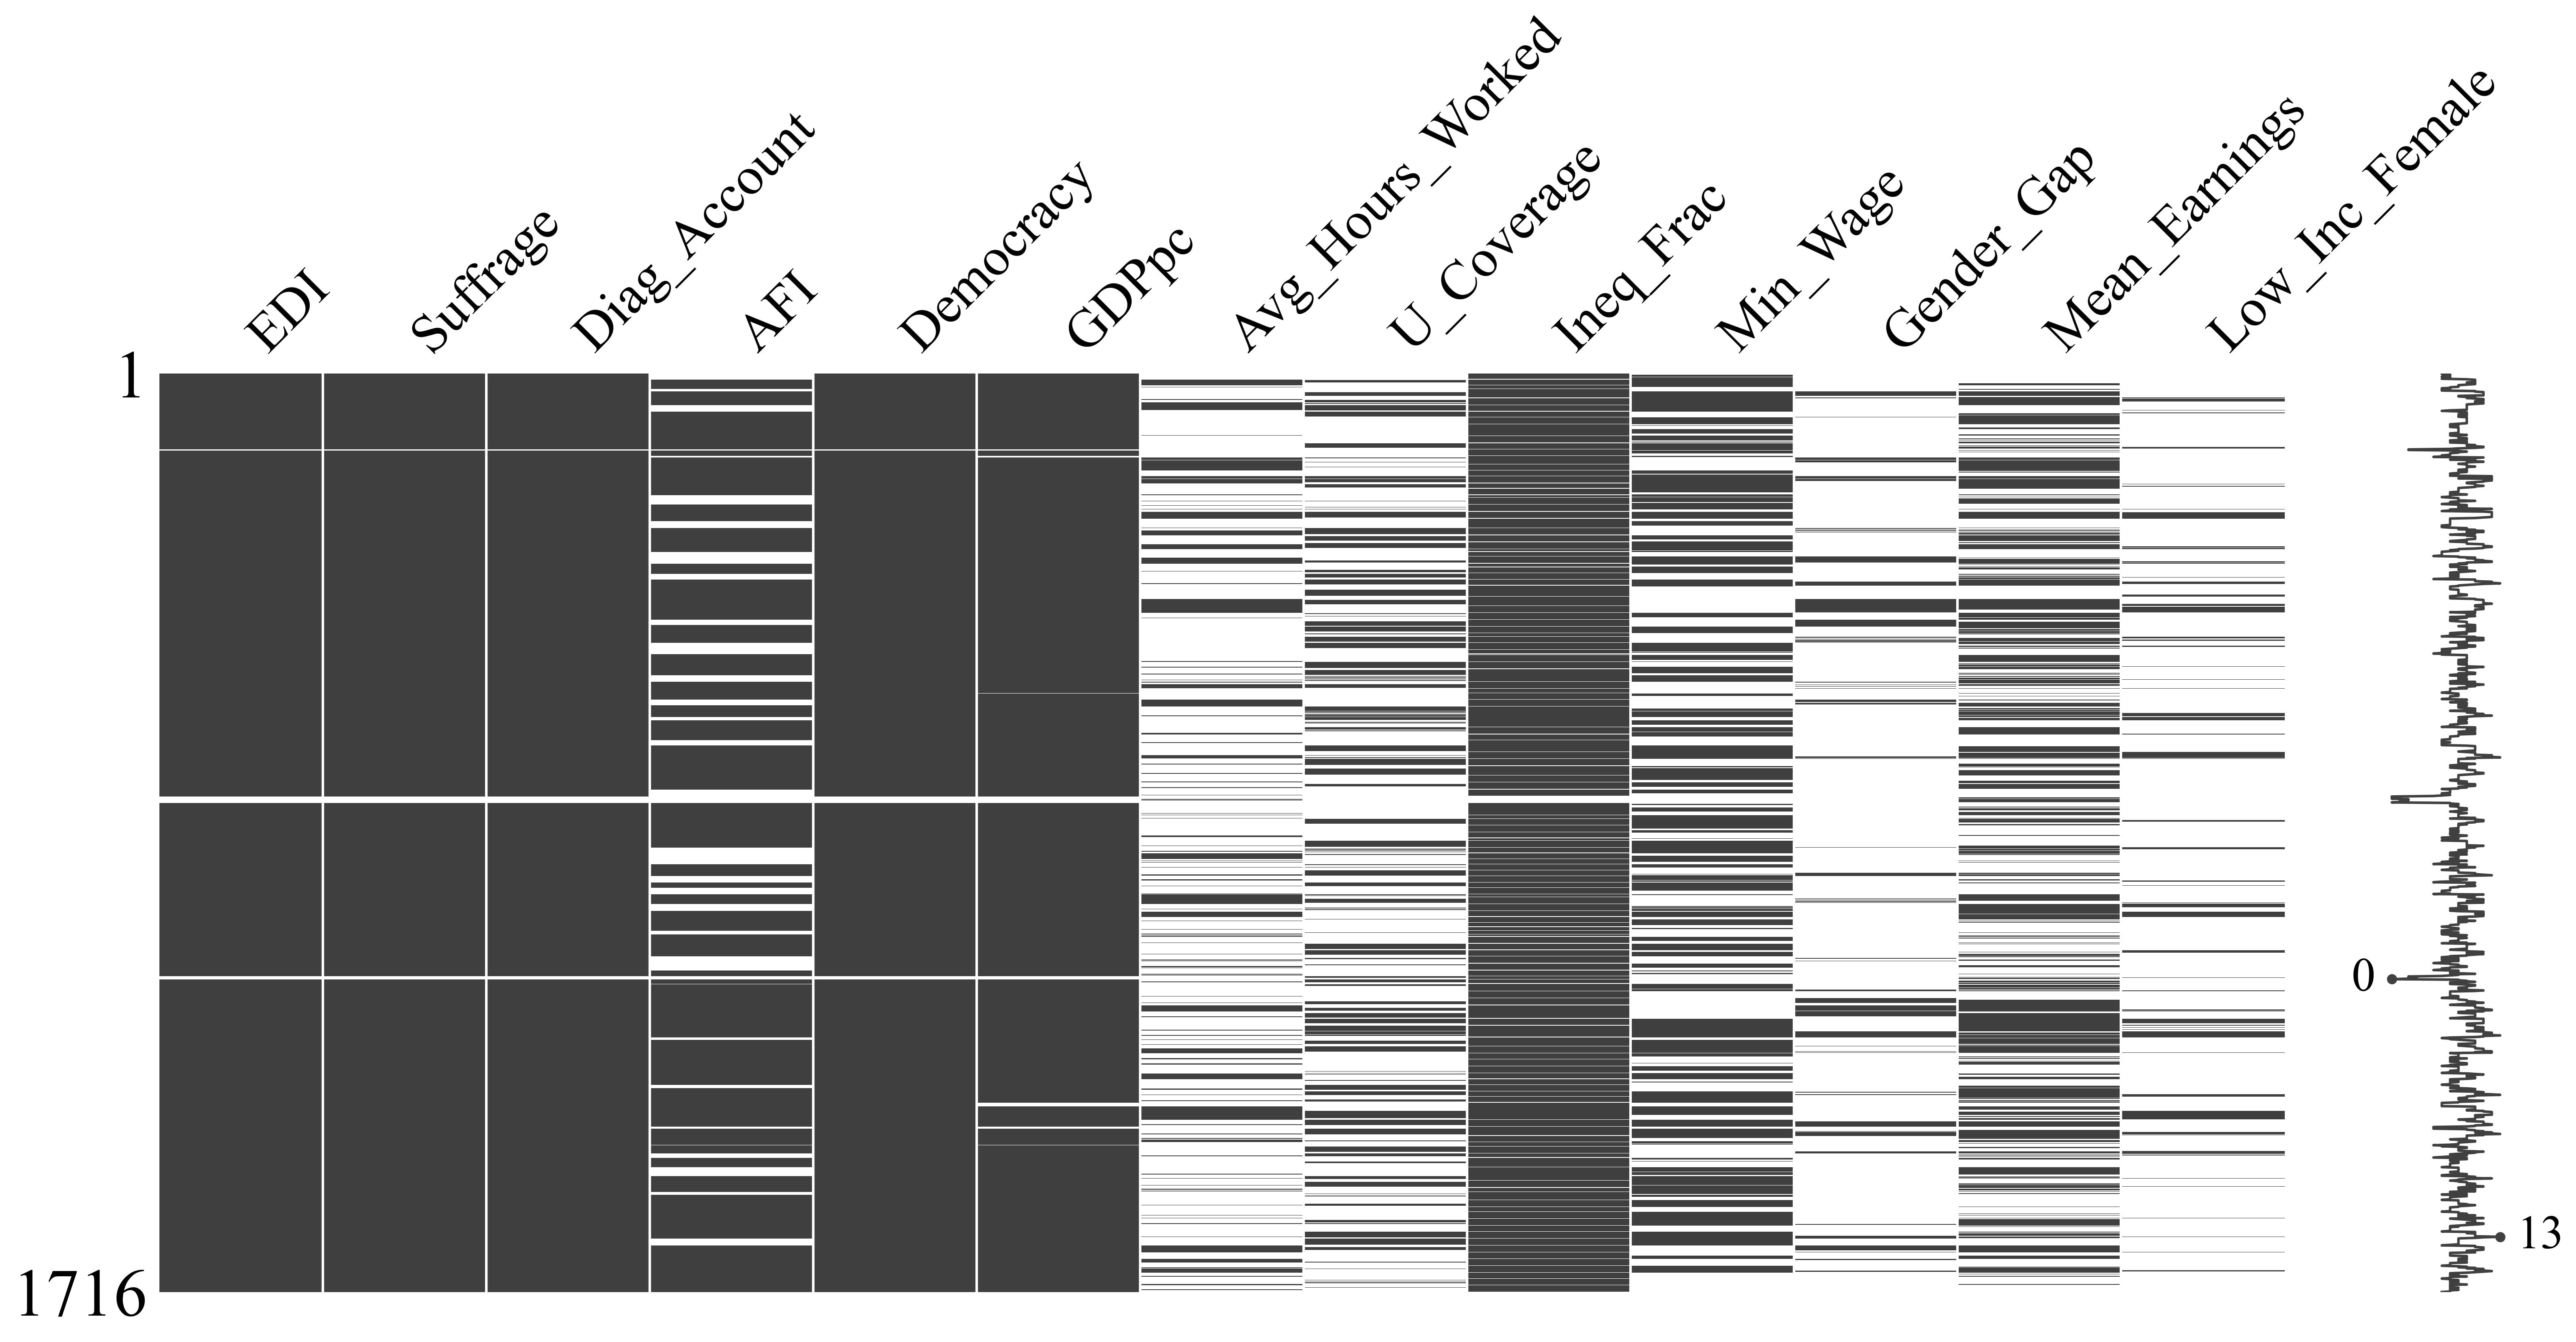

In [121]:
# Rename columns for visualization
df_miss = df.drop(["Country", "Year", "Life_Satisfaction", "U_Density", "Ineq_Diff"], axis = 1)

miss.matrix(df_miss, fontsize = 32)#.set_title("Missing Data in Raw Dataset")
plt.savefig("Figures/Missing_Data_Raw.png", bbox_inches = 'tight')

In [75]:
df.isnull().sum(axis = 0)

Country                 0
Year                    0
Life_Satisfaction       0
EDI                    20
Suffrage               20
Diag_Account           20
AFI                   357
Democracy              20
GDPpc                  36
Avg_Hours_Worked     1330
U_Coverage           1141
U_Density            1141
Ineq_Diff             147
Ineq_Frac             147
Min_Wage              786
Gender_Gap           1502
Mean_Earnings         897
Low_Inc_Female       1520
dtype: int64

It appears that data on hours worked, union membership, work safety, gender pay gap, and the percent of low income earners that are female are incredibly sparse. It is likely these missing values are for the same countries. Because we will be using fixed effects later, this may prove less important as some countries will then be able to use these features. 

That said, there appear to be some countries with life satisfaction data but nothing else. Countries missing `Democracy` data will be removed, and this will be stored as a separate dataset.

In [76]:
# Entries missing democracy data
print("Number of observations which would be removed: " + str(len(df.loc[df["Democracy"].isnull()])))
df["Country"].loc[df["Democracy"].isnull()].unique()

Number of observations which would be removed: 20


array(['Belize', 'Kosovo', 'Cyprus'], dtype=object)

Above are the countries with little to no data.

In [77]:
# Removes all data which is missing democracy information
df = df.loc[~df["Democracy"].isnull()]

In [78]:
# Drops union density rate
df = df.drop(["U_Density"], axis = 1)

In [79]:
# Reorders the indicies
df = df.reset_index(drop = True)

In [80]:
len(df)

1696

In [81]:
#save_df_as_image(df.sample(5), 'Figures/Full_Data.png')

In [82]:
# Saves the new dataframe
# , "Gender_Gap", "Low_Inc_Female"
df.drop(["Ineq_Diff", "Year"], axis = 1).to_csv("../Data/GeneratedData/Cleaned_Data_Full.csv")

We're going to make one more dataset that will impute missing values.

In [83]:
df_Imputed = df.copy()

What's important here is that we are NOT imputing using `Life_Satisfaction`. That would create a causal relationship between the imputed values and happiness, our outcome variable.

In [84]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df.dropna().drop(["Country", "Year", "Life_Satisfaction"], axis = 1))

IterativeImputer(random_state=0)

In [85]:
df_Imputed = pd.DataFrame(imp.transform(df.drop(["Country", "Year", "Life_Satisfaction"], axis = 1)), columns = df.columns[3:])

In [86]:
df_Imputed = pd.concat([df[["Country", "Year", "Life_Satisfaction"]], df_Imputed], axis = 1)

In [87]:
df_Imputed.sample(5)

,Country,Year,Life_Satisfaction,EDI,Suffrage,Diag_Account,AFI,Democracy,GDPpc,Avg_Hours_Worked,U_Coverage,Ineq_Diff,Ineq_Frac,Min_Wage,Gender_Gap,Mean_Earnings,Low_Inc_Female
1530,Turkey,2012,5.309076,0.582,100.0,0.629,0.409,1.0,18170.000000,49.159917,18.987157,31.545173,20.666724,523.660000,-58.781299,59.548138,34.209413
1023,Mozambique,2011,4.971112,0.469,100.0,0.770,0.631,0.0,925.000000,56.355796,21.382723,76.740814,138.088643,106.650000,-197.006047,-2576.656416,6.582829
802,Kyrgyz Republic,2010,4.996411,0.332,100.0,0.699,0.574,0.0,3977.648893,66.424189,20.089151,26.723531,9.246081,10.880000,-138.435530,-2222.857459,11.483654
1143,Palestine,2015,4.695239,0.252,100.0,0.592,0.569,0.0,5003.000000,43.200000,24.182972,40.743586,19.557107,866.816292,-127.316917,-1506.496748,13.069928
1610,Uruguay,2007,5.693946,0.892,100.0,0.974,0.968,1.0,13976.392579,39.547300,16.167883,35.215756,17.508306,203.034222,11.020000,434.880000,27.361348


In [88]:
df_Imputed.isnull().sum(axis = 0)

Country              0
Year                 0
Life_Satisfaction    0
EDI                  0
Suffrage             0
Diag_Account         0
AFI                  0
Democracy            0
GDPpc                0
Avg_Hours_Worked     0
U_Coverage           0
Ineq_Diff            0
Ineq_Frac            0
Min_Wage             0
Gender_Gap           0
Mean_Earnings        0
Low_Inc_Female       0
dtype: int64

In [89]:
# save_df_as_image(df_Imputed.sample(5), 'Figures/Imputed_Data.png')

In [90]:
# Saves the new dataframe
df_Imputed.drop(["Year", "Ineq_Diff", "Democracy"],axis = 1).to_csv("../Data/GeneratedData/Cleaned_Data_Imputed.csv")

## Correlation

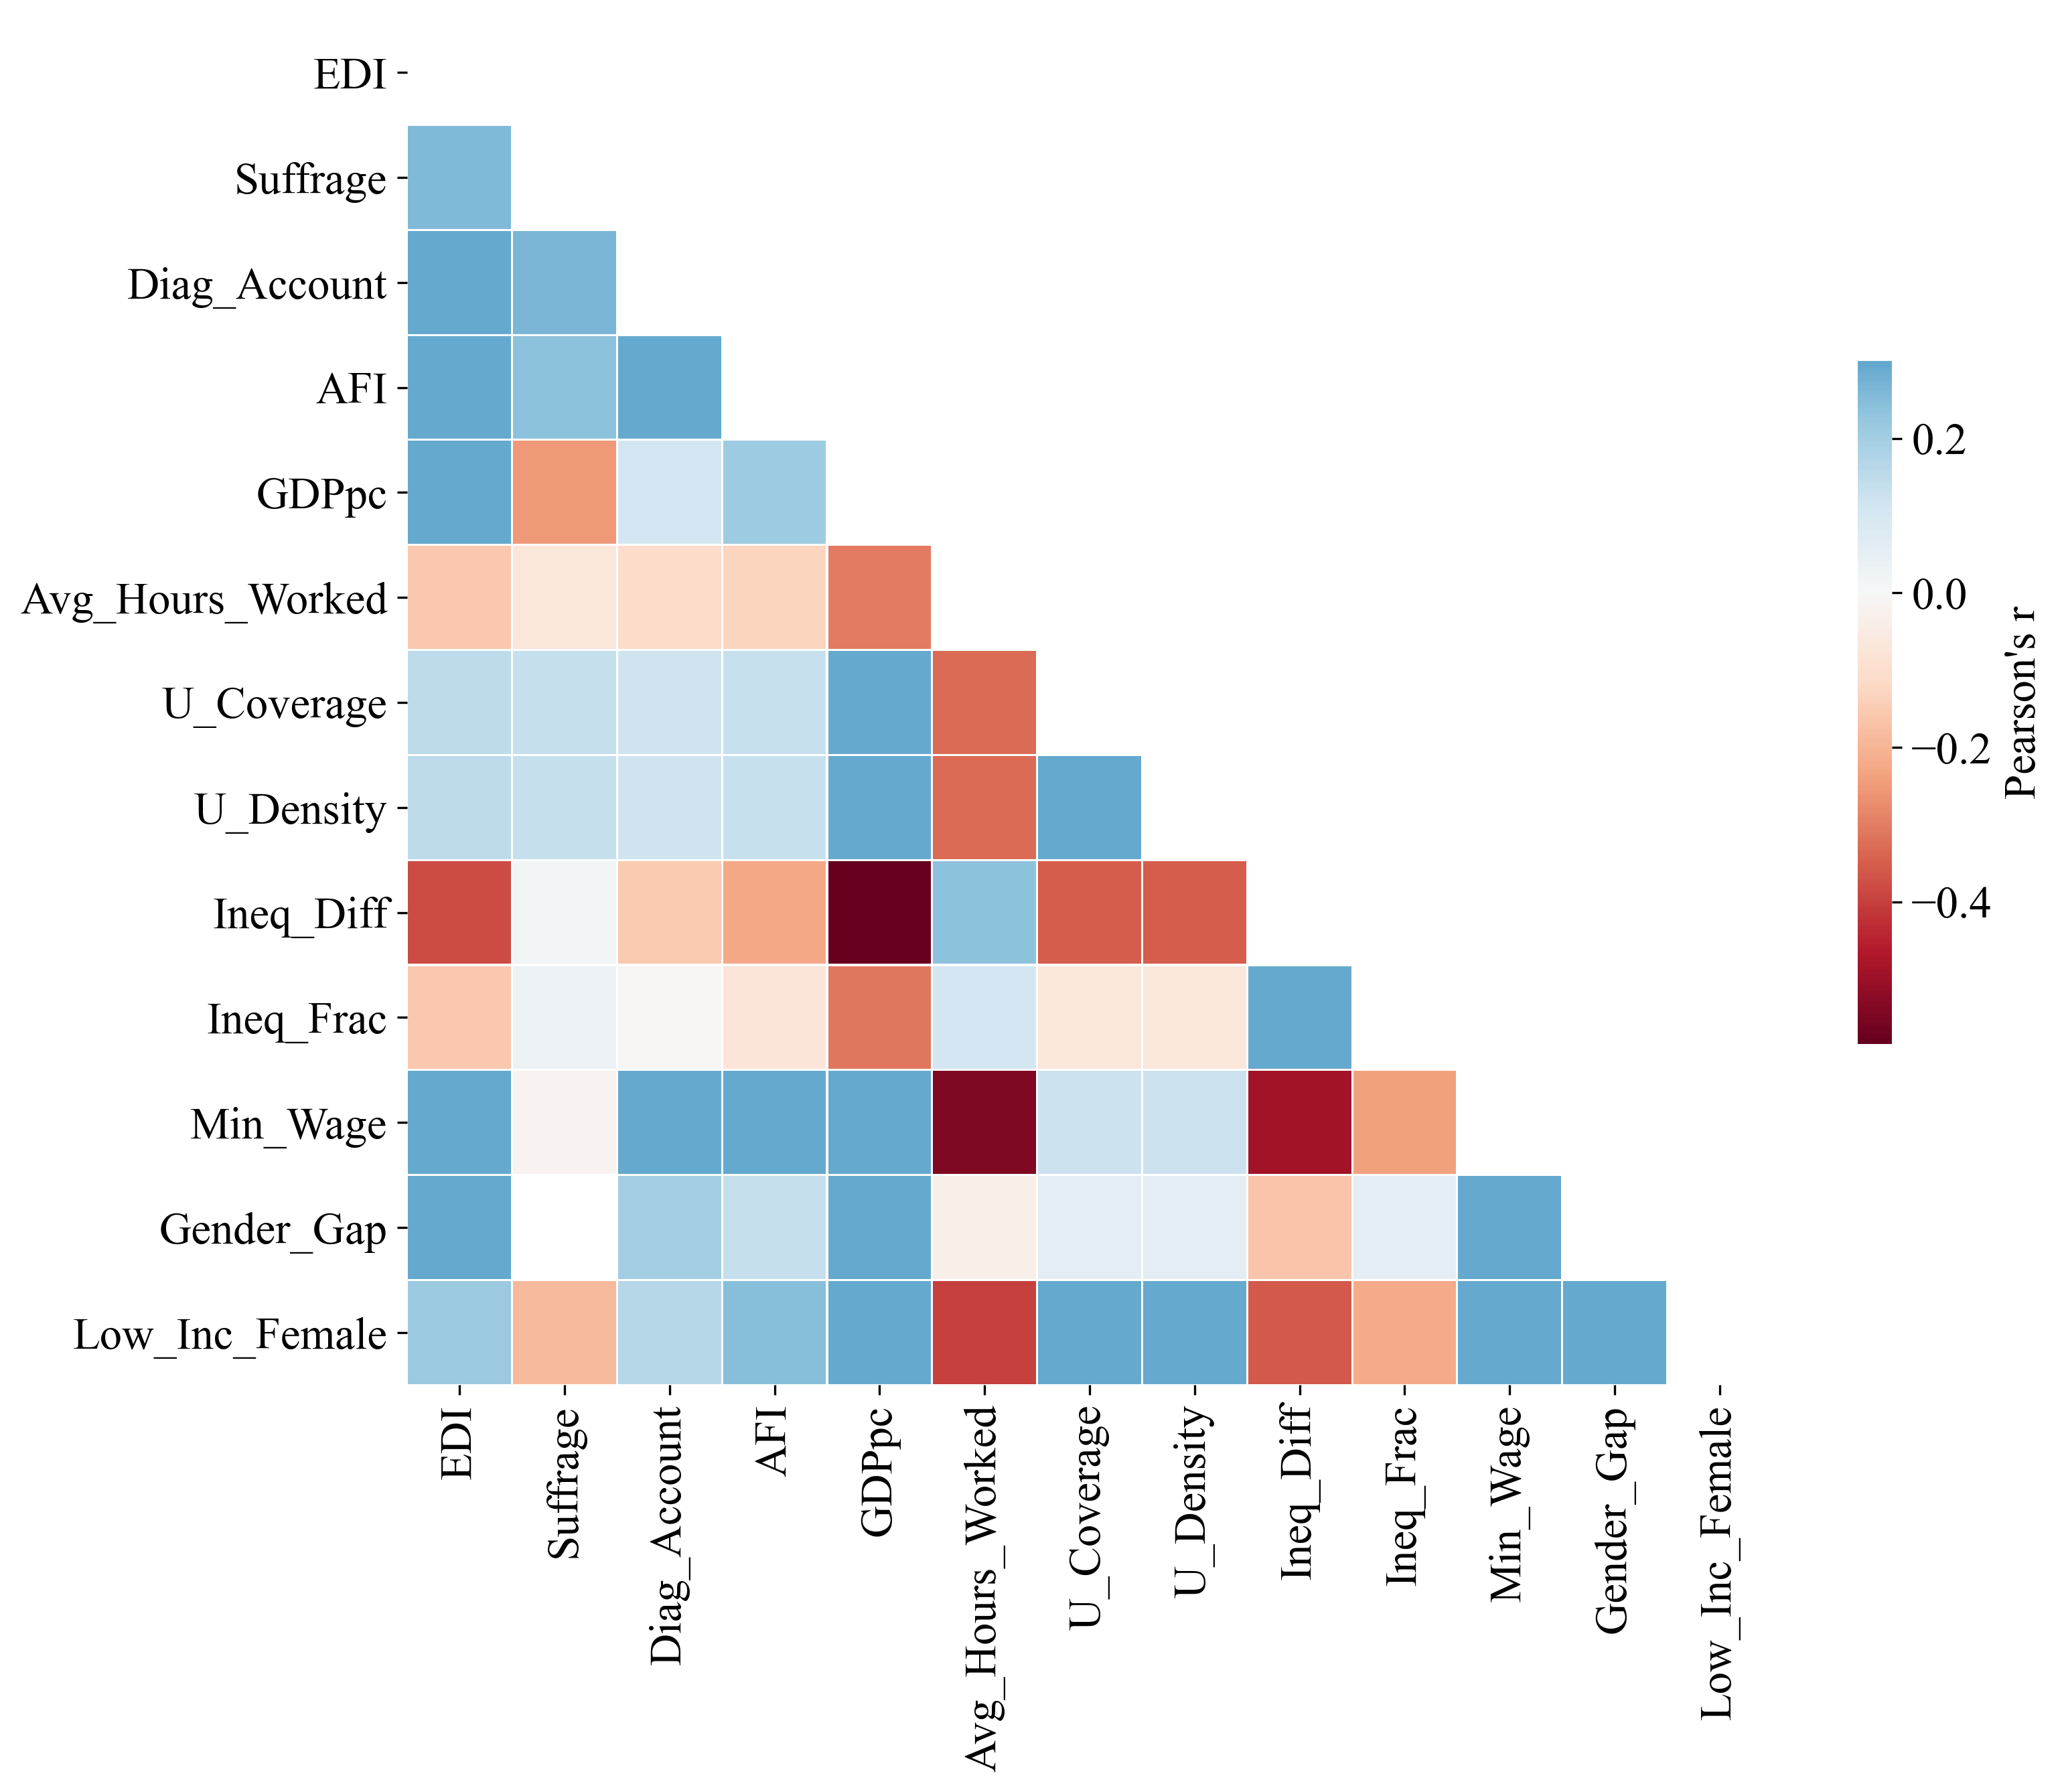

In [113]:
# The following code was modified from this python example:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Determines the correlation between variables
corr = df.drop(["Life_Satisfaction", "Democracy", "Mean_Earnings"],axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap= cm.get_cmap('RdBu'), vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, "label": "Pearson's r"})#.set_title("Feature Correlations for Full Dataset")
#plt.xticks(rotation=65) 
plt.savefig("Figures/Feat_Corr_Raw.png",bbox_inches = 'tight')

There are two instances of extreme multicollinearity between the input variables, being for GDPpc and inequality (difference) and also between satutory minimum wage and average hours worked. There is moderate correlation. For the variables from VDEM, regime type is calculated using the electoral democracy index. Only one of the variables for unions should be used, as they are likely causally related. Otherwise, there do not appear to be causal links between any other variables.

Inequality difference seems to correlate moderately or extremely with most variables, and as such, we will use the inequality fraction function.

Statutory minimum wage will be kept while average hours worked and average monthly earnings will be dropped. This is because of the data saved by keeping minimum wage, and it correlates strongly with the other variables.

Both gender pay gap and share of female low income earners will be dropped as these variables are too sparse.

Academic Freedom will be dropped due to work later on. It appears that AFI may not be related to work satisfaction and may have some confounders.

In [92]:
# Keeps only required variables
df = df[["Country", "Life_Satisfaction", "Diag_Account", "EDI", "Suffrage", 
         "GDPpc", "Min_Wage", "U_Coverage", "Ineq_Frac"]] # , "AFI"

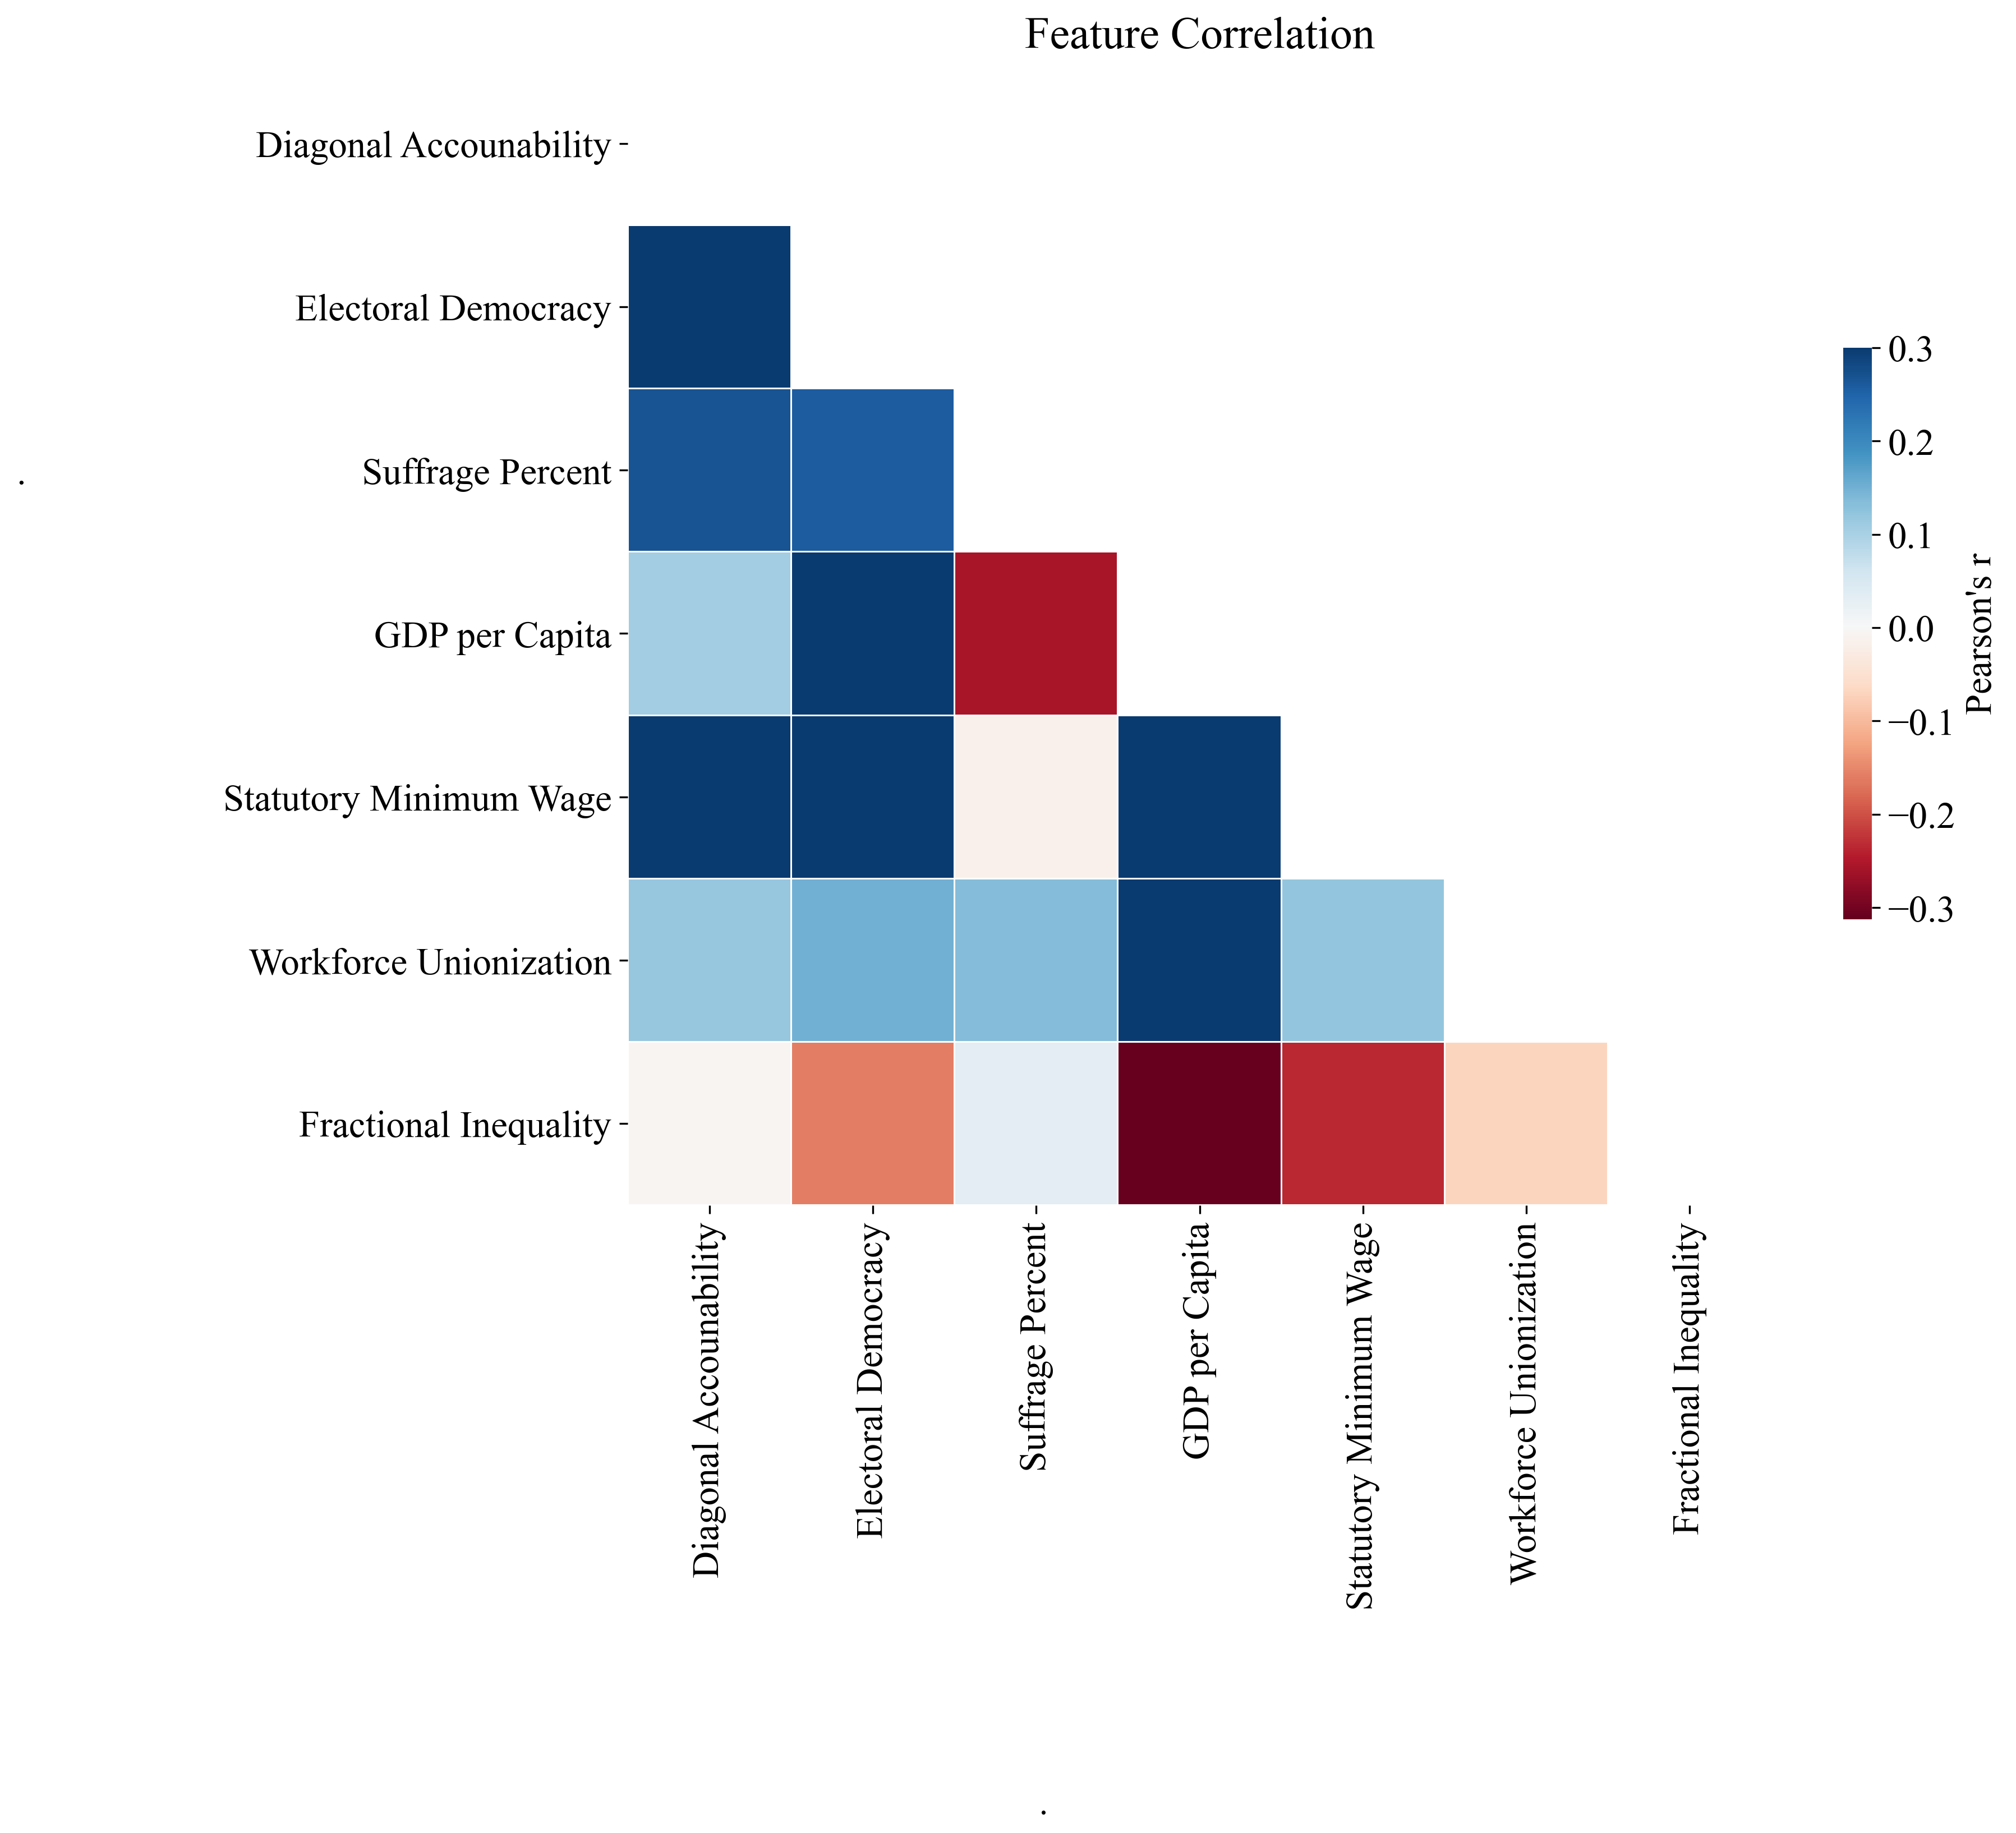

In [93]:
# The following code was modified from this python example:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Rename columns for visualization
df_corr = df.rename({"Diag_Account": "Diagonal Accounability",
                     "EDI": "Electoral Democracy", 
                     "Suffrage":".                                    Suffrage Percent", 
                     "GDPpc":"GDP per Capita", 
                     "Min_Wage":"Statutory Minimum Wage", 
                     "Mean_Earnings":"Mean Monthly Earnings",
                     "U_Coverage":"Workforce Unionization", 
                     "Ineq_Frac":"Fractional Inequality"}, axis = 1) #, "AFI":"Academic Freedom"

# Determines the correlation between variables
corr = df_corr.drop(["Life_Satisfaction"],axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap= cm.get_cmap('RdBu'), vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, "label": "Pearson's r"}).set_title("Feature Correlation")
plt.savefig("Figures/Feat_Corr_Reduced.png", dpi = 300, bbox_inches = 'tight')

Just to check some of the highly correlated values, see the scatterplots below.

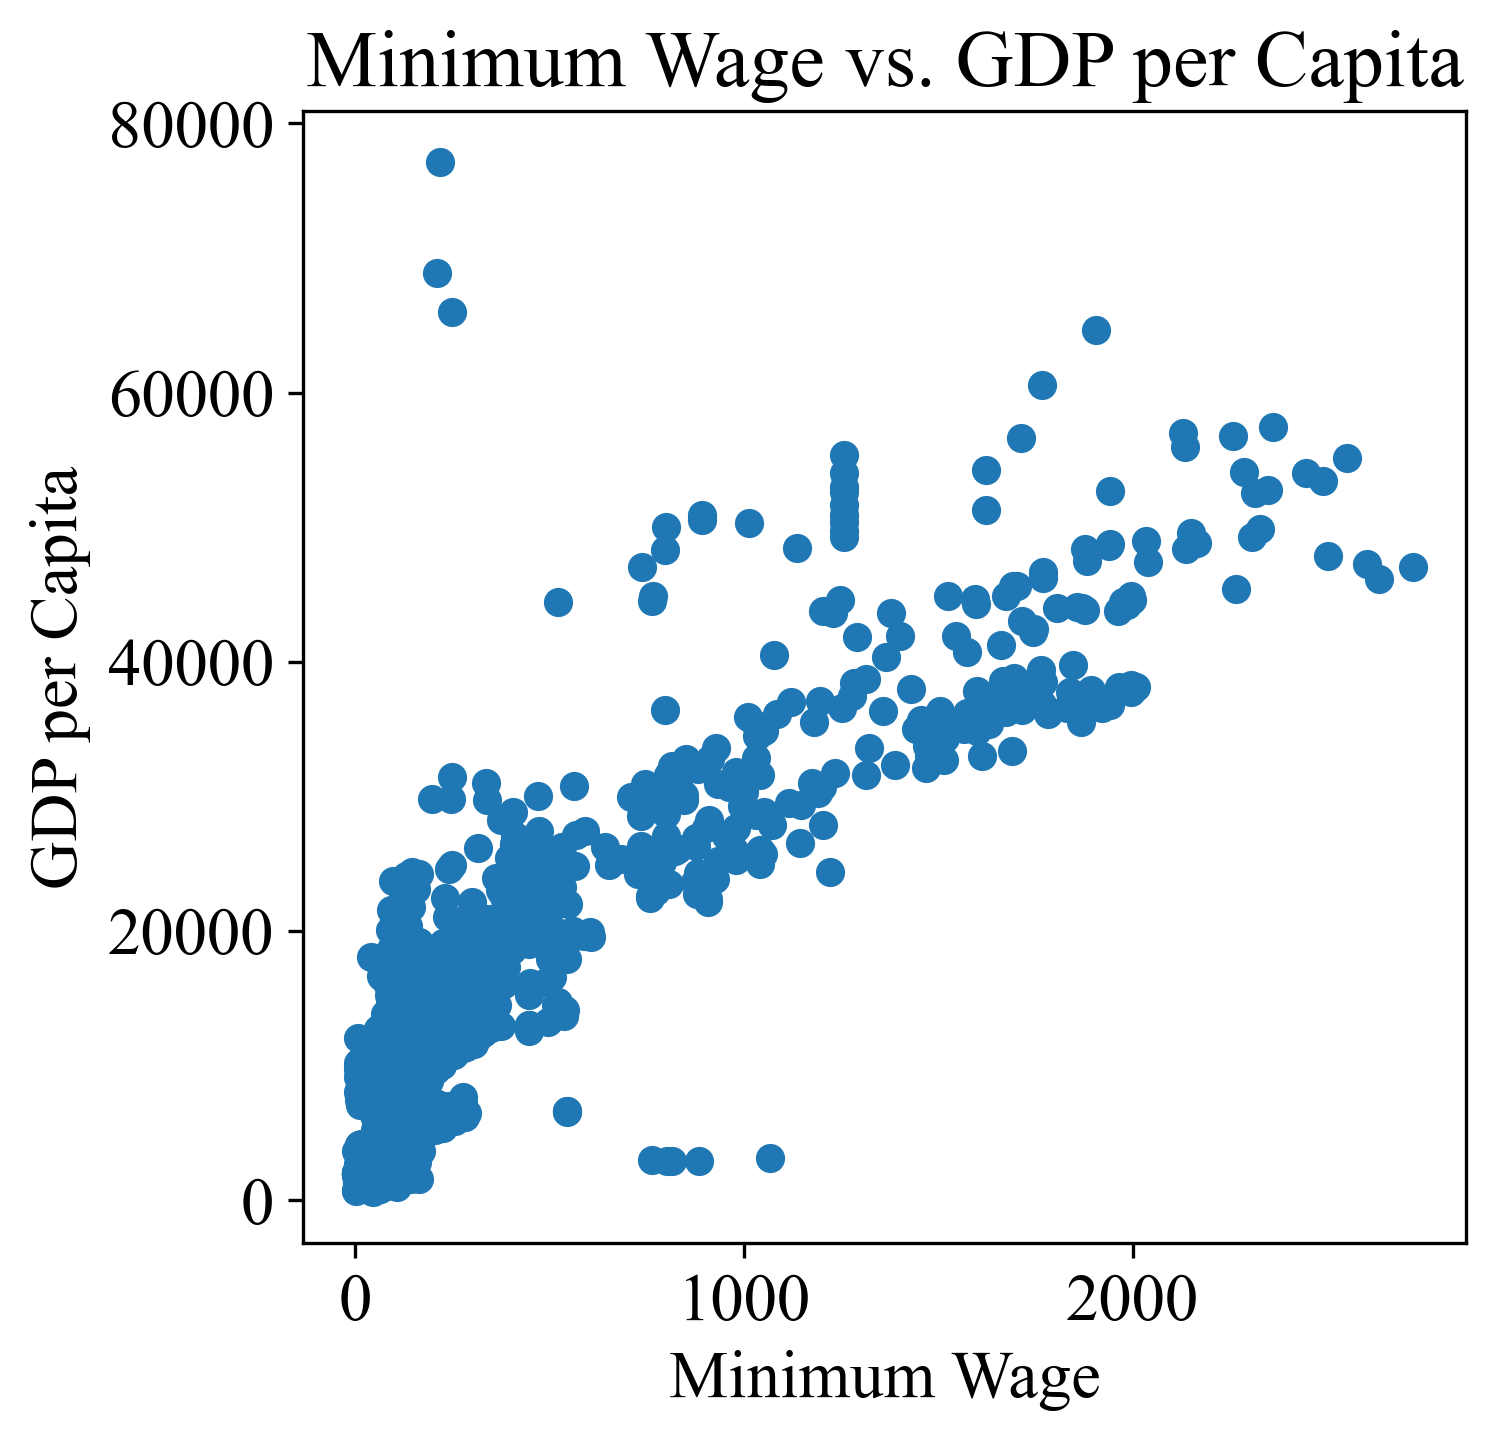

In [94]:
plt.scatter(df["Min_Wage"], df["GDPpc"])
plt.title("Minimum Wage vs. GDP per Capita")
plt.xlabel("Minimum Wage")
plt.ylabel("GDP per Capita")
plt.savefig("Figures/Scatter_MinWage_GDPpc.png", dpi = 300, bbox_inches = 'tight')

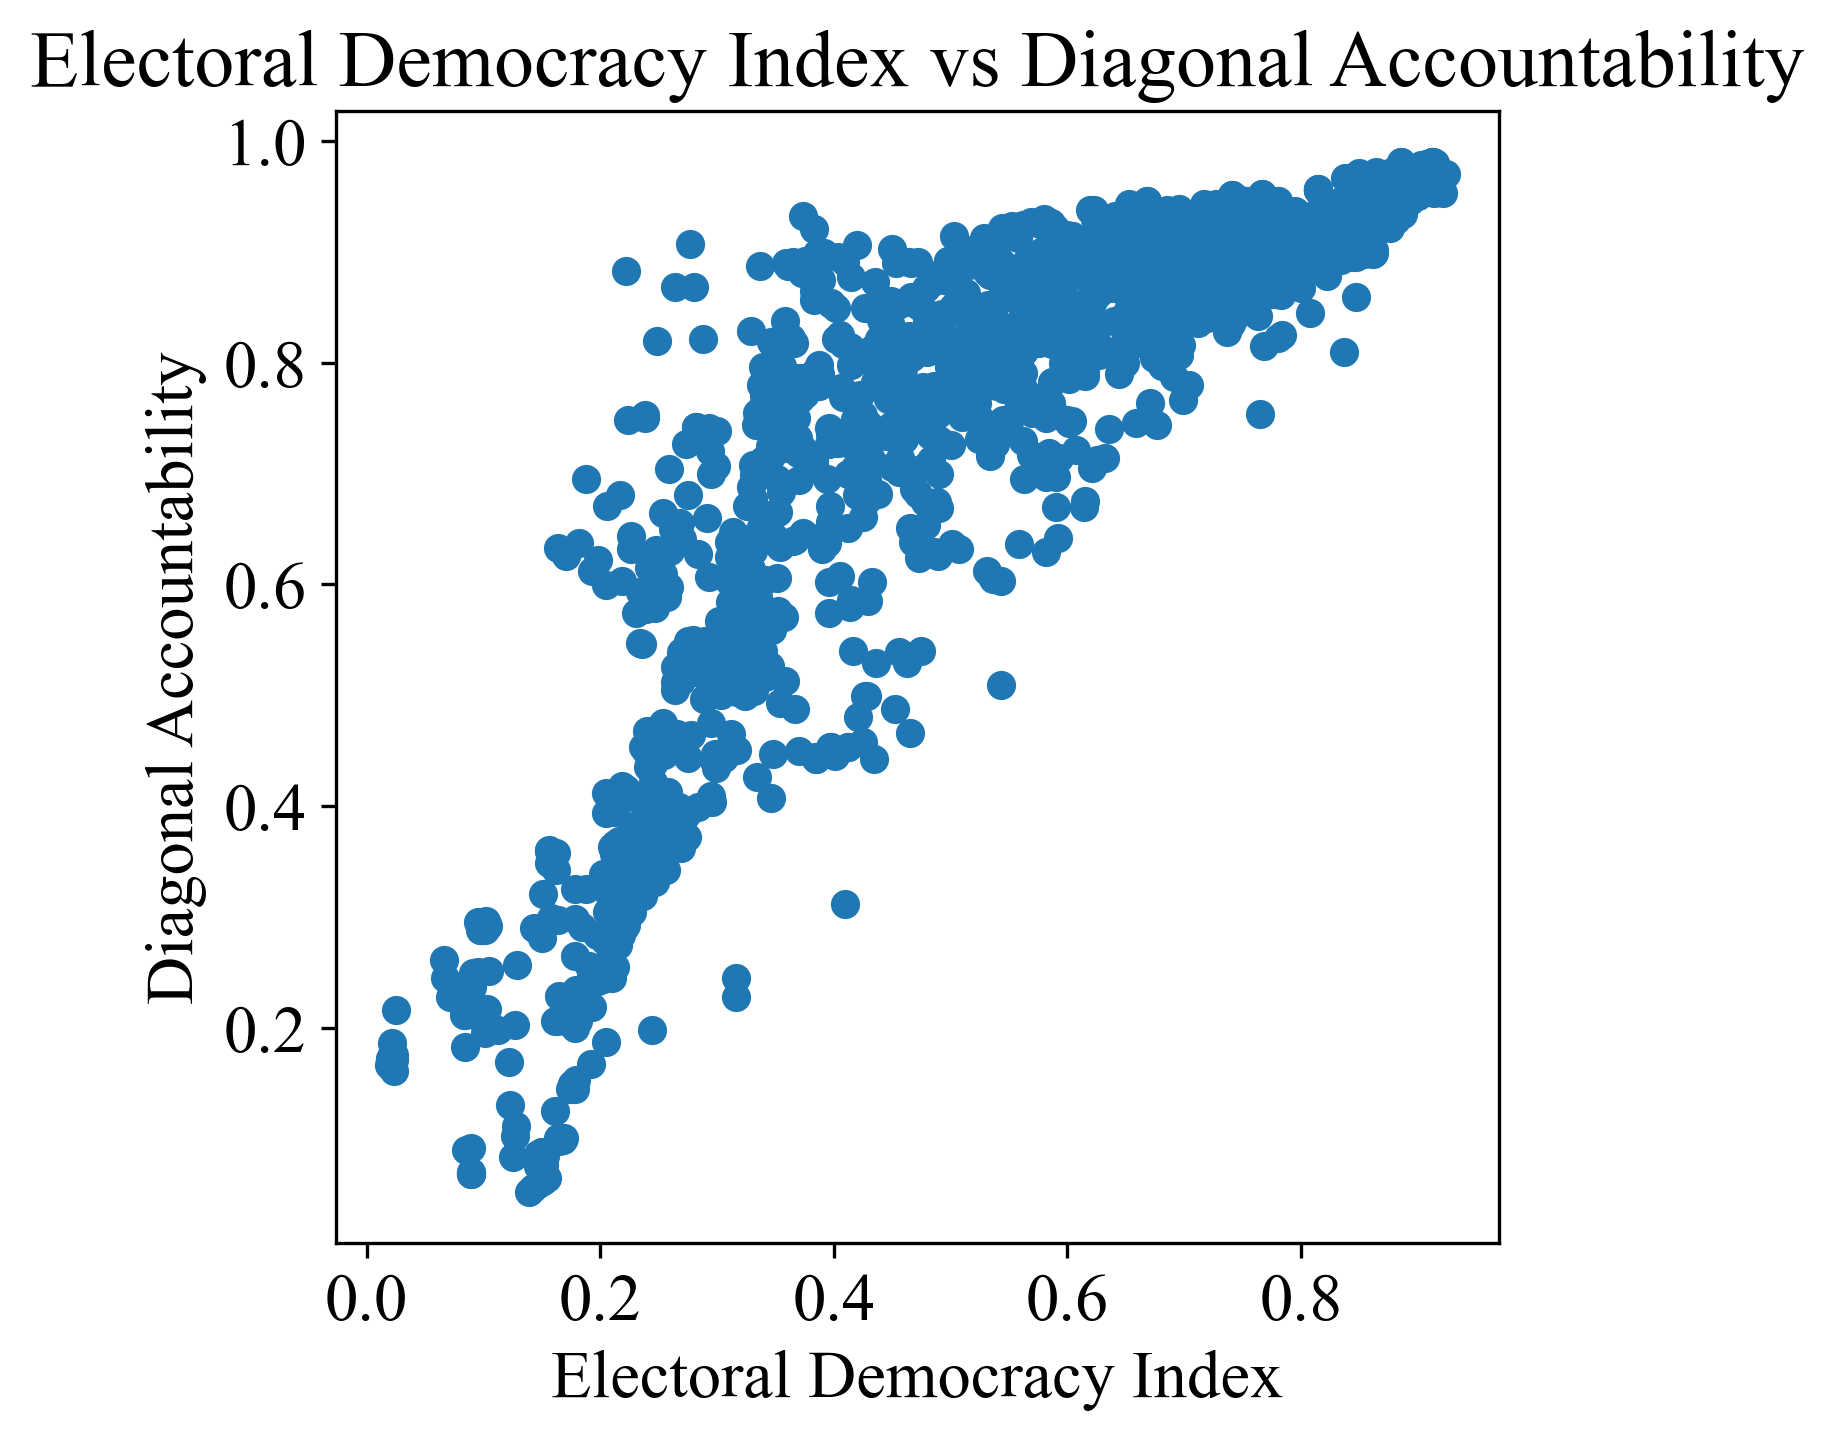

In [95]:
plt.scatter(df["EDI"], df["Diag_Account"])
plt.title("Electoral Democracy Index vs Diagonal Accountability")
plt.xlabel("Electoral Democracy Index")
plt.ylabel("Diagonal Accountability")
plt.savefig("Figures/Scatter_DemIndex_Accountability.png", dpi = 300, bbox_inches = 'tight')

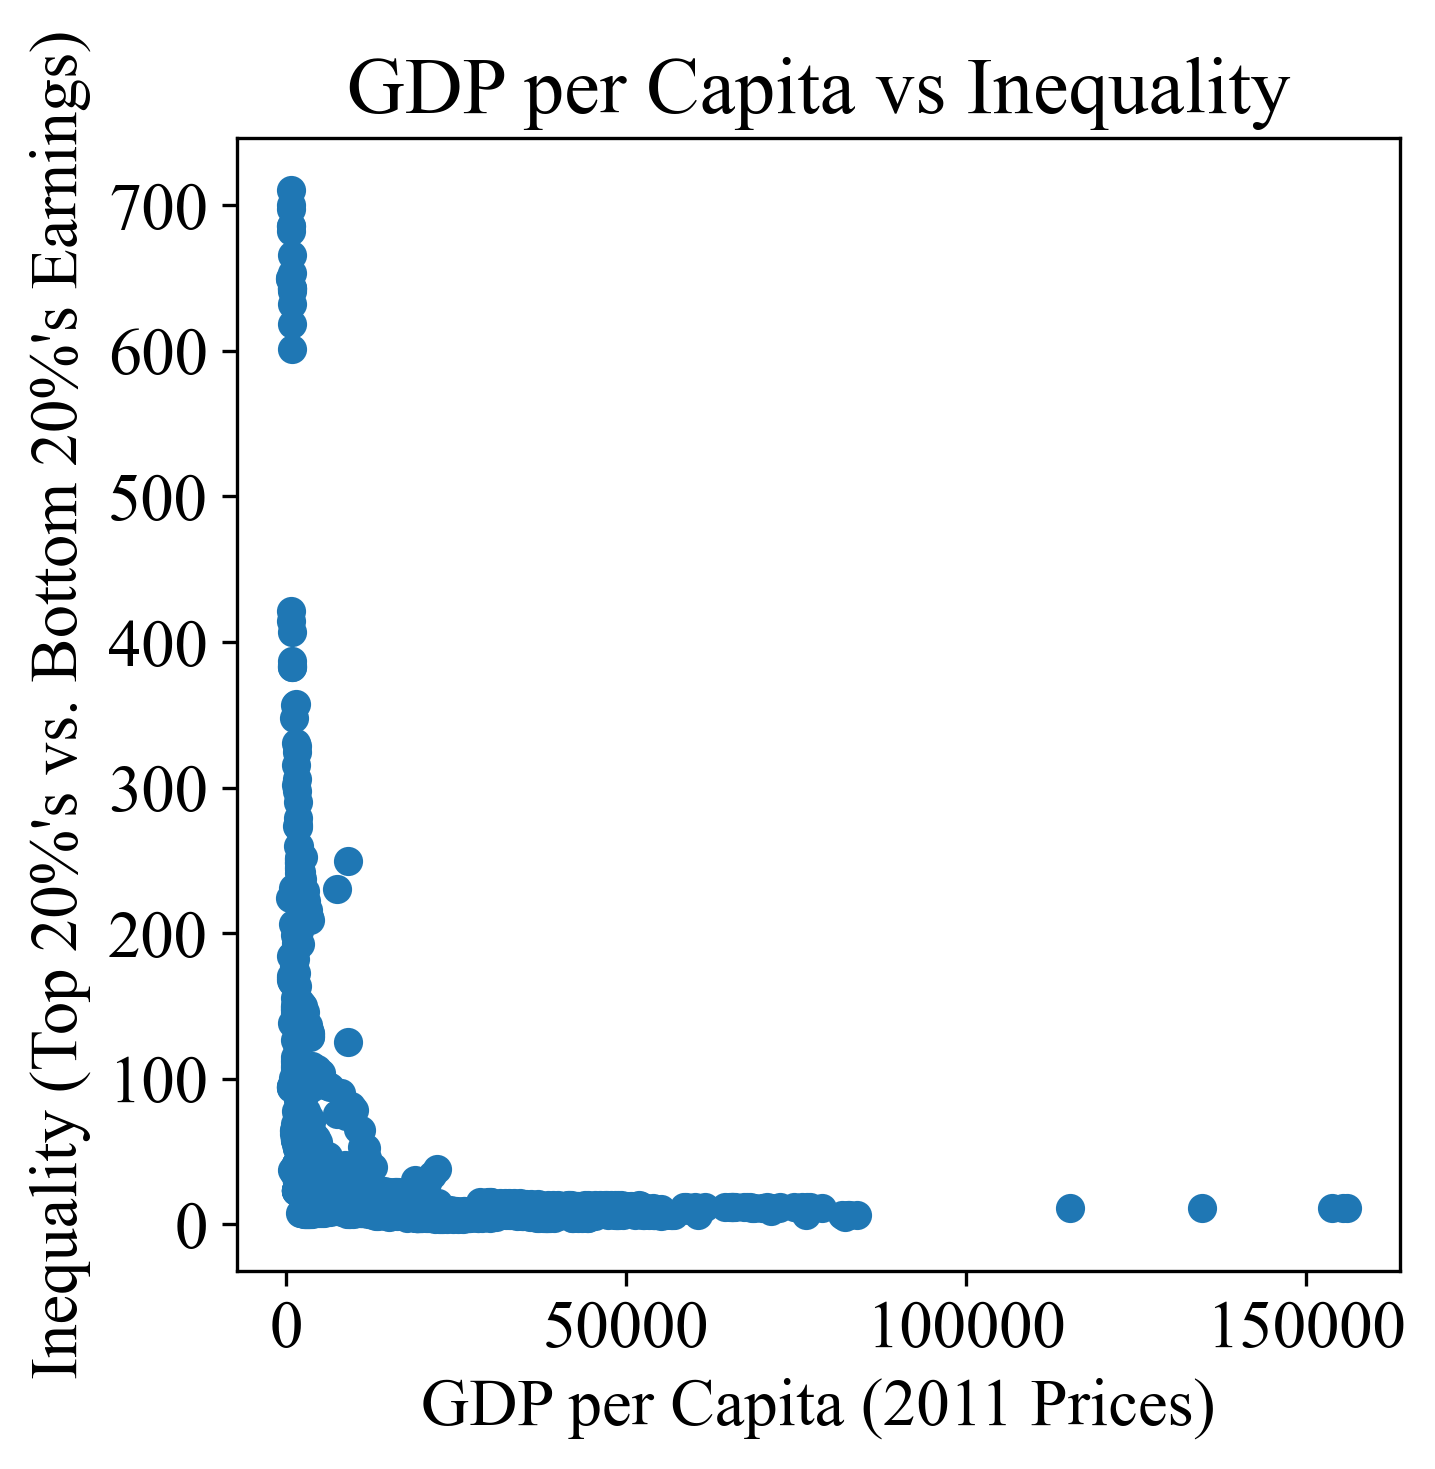

In [96]:
plt.scatter(df["GDPpc"], df["Ineq_Frac"])
plt.title("GDP per Capita vs Inequality")
plt.xlabel("GDP per Capita (2011 Prices)")
plt.ylabel("Inequality (Top 20%'s vs. Bottom 20%'s Earnings)")
plt.savefig("Figures/Scatter_GDPpc_Ineq.png", dpi = 300, bbox_inches = 'tight')

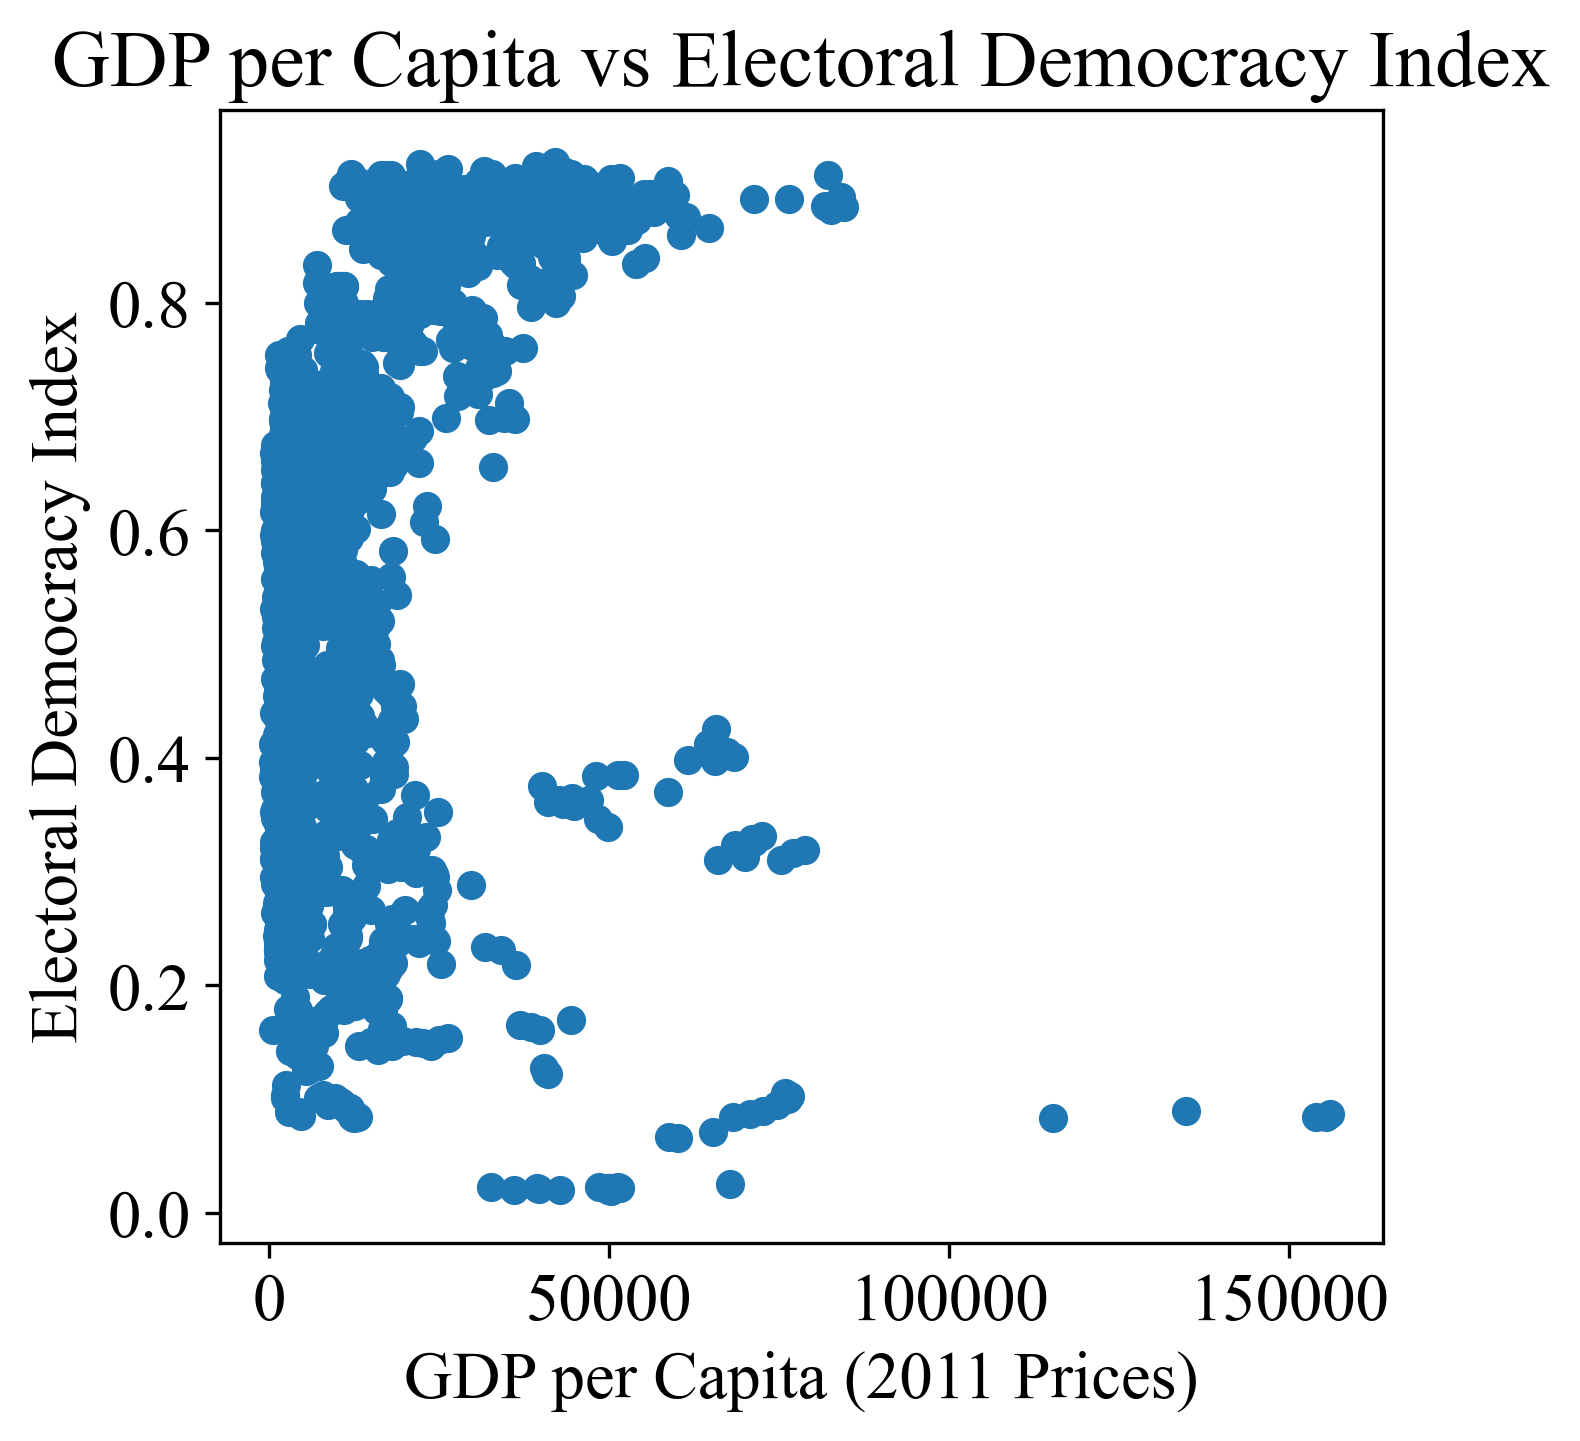

In [97]:
plt.scatter(df["GDPpc"], df["EDI"])
plt.title("GDP per Capita vs Electoral Democracy Index")
plt.xlabel("GDP per Capita (2011 Prices)")
plt.ylabel("Electoral Democracy Index")
plt.savefig("Figures/Scatter_GDPpc_DemIndex.png", dpi = 300, bbox_inches = 'tight')

We now have a set of descriptive variables, each controlling for different aspects of a nation's government, economy, and working conditions.

In [98]:
# Removes all data which is missing AFI information
#df = df.loc[~df["AFI"].isnull()]

# Removes all data which is missing Fractional Inequality information
df = df.loc[~df["Ineq_Frac"].isnull()]

# Removes all data which is missing GDP per Capita information
df = df.loc[~df["GDPpc"].isnull()]

In [99]:
# Drop variables that are too spares
df = df.drop(["Min_Wage"], axis = 1)

In [100]:
# Creates a dataframe where each value is guaranteed to have a non-null union coverage
df_union = df.loc[~df["U_Coverage"].isnull()]

# Saves the new dataframe
df_union.to_csv("../Data/GeneratedData/Cleaned_Data_Union.csv")

In [101]:
len(df_union)

572

In [102]:
# Drop variables that are too spares
df = df.drop(["U_Coverage"], axis = 1)

In [103]:
df.isnull().sum(axis = 0)

Country              0
Life_Satisfaction    0
Diag_Account         0
EDI                  0
Suffrage             0
GDPpc                0
Ineq_Frac            0
dtype: int64

In [104]:
#save_df_as_image(df.sample(5), 'Figures/Restricted_Data.png')

In [105]:
# Saves the new dataframe
df.to_csv("../Data/GeneratedData/Cleaned_Data_Restricted.csv")

In [106]:
len(df)

1546